In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from library.sb_utils import save_file

In [3]:
path = r"C:\Users\adame\OneDrive\Documents\GitHub\springboard_repository\Capstone_three\data\processed\eda_churn_data.csv"
df = pd.read_csv(path)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,average_monthly_charges,customer_lifetime_value,cust_CLV
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,new,29.850000,29.85,967.790316
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,No,medium_term,55.573529,1889.50,61260.964875
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,new,54.075000,108.15,3506.416169
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,medium_term,40.905556,1840.75,59680.402801
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,new,75.825000,151.65,4916.763865


In [5]:
# drop the customer ID column, it does not add value to the model
df.drop(columns=['customerID', 'cust_CLV', 'average_monthly_charges'], inplace=True)

Encode categorical variables

In [6]:
# create a list of categorical features
categorical = df.nunique()[df.nunique() < 5].keys().tolist()
print(categorical)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'tenure_group']


In [7]:
# find numerical columns
numeric = [x for x in df.columns if x not in categorical]
numeric.remove('customer_lifetime_value')
numeric

['tenure', 'MonthlyCharges', 'TotalCharges']

In [8]:
# use pandas get_dummies to encode categorical columns
df_encoded = pd.get_dummies(data=df, columns=categorical, drop_first=True, dtype=int)
df_encoded.head()

,tenure,MonthlyCharges,TotalCharges,customer_lifetime_value,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,tenure_group_medium_term,tenure_group_new
0,1,29.85,29.85,29.85,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,1
1,34,56.95,1889.50,1889.50,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,1,0
2,2,53.85,108.15,108.15,1,0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,1
3,45,42.30,1840.75,1840.75,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
4,2,70.70,151.65,151.65,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,1


Create X and y datasets

In [9]:
X = df_encoded.drop(columns=['customer_lifetime_value'], axis=1)
y = df.customer_lifetime_value
print(X.shape, y.shape)

(7032, 33) (7032,)


Scale the data

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split the data into train and test sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5274, 33) (1758, 33) (5274,) (1758,)


Evaluate model with mean squared error and mean absolute error, then compare with baseline

In [13]:
# baseline metrics
y_train_mean_value = np.mean(y_train)

# Baseline predictions using the mean
baseline_predictions = np.full_like(y_train, y_train_mean_value)

# Calculate baseline MSE and MAE
baseline_mse = round(mean_squared_error(y_train, baseline_predictions, squared=False), 2)
baseline_mae = round(mean_absolute_error(y_train, baseline_predictions), 2)

print(f'Baseline MSE: {baseline_mse}')
print(f'Baseline MAE: {baseline_mae}')

Baseline MSE: 2259.79
Baseline MAE: 1891.94


GridSearchCV on Gradient Boost Regressor

In [14]:
param_grid = {
    'n_estimators': [300, 400],  # Number of boosting stages
    'learning_rate': [0.01, 0.05],  # Step size shrinkage
    'max_depth': [3, 4],  # Maximum depth of the individual regression estimators
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'max_features': [1, 2],  # Number of features to consider when looking for the best split
    'subsample': [0.8],  # Fraction of samples used for fitting the individual base learners
    'loss': ['squared_error', 'absolute_error', 'huber'],  # Loss function to be optimized
}

In [15]:
# instantiate the gradient boost model and the grid search model
GradBoost_model = GradientBoostingRegressor(random_state=42)
gradBoost_grid_search_model = GridSearchCV(estimator=GradBoost_model, param_grid=param_grid, n_jobs=-1, cv=5)

In [16]:
# fit the grid search model
gradBoost_grid_search_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05],
                         'loss': ['squared_error', 'absolute_error', 'huber'],
                         'max_depth': [3, 4], 'max_features': [1, 2],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [300, 400], 'subsample': [0.8]})

In [17]:
# print out the best parameters for the model
gradBoost_grid_search_model.best_params_

{'learning_rate': 0.05,
 'loss': 'squared_error',
 'max_depth': 4,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400,
 'subsample': 0.8}

In [18]:
# pick the best version of the model and assign it to a variable
best_gradBoost_model = gradBoost_grid_search_model.best_estimator_

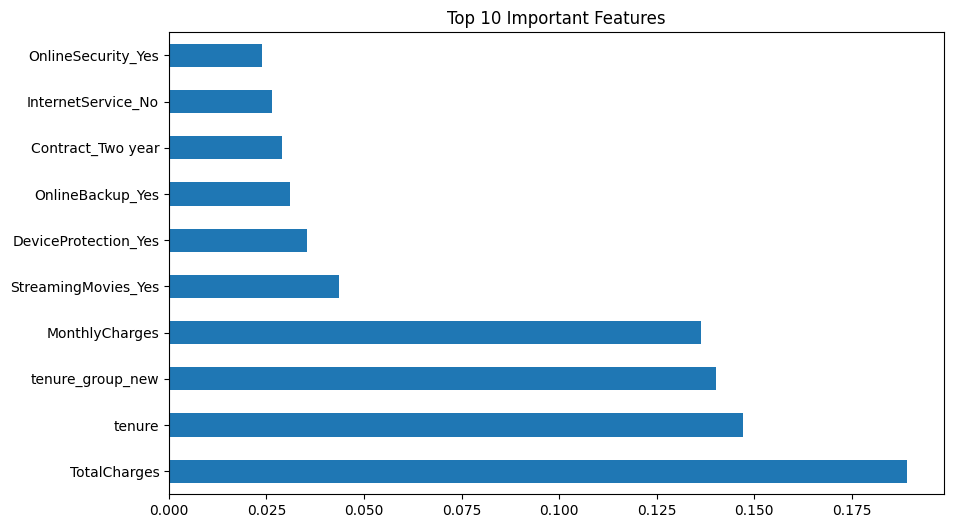

In [19]:
# get the important features
gb_model_important_features = best_gradBoost_model.feature_importances_
# get the column names
columns = X.columns
# combine the feature importance with the column names
feature_importance = pd.Series(gb_model_important_features, index=columns)

#plot the feature importance
plt.figure(figsize=(10, 6))
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()


In [20]:
# make predictions using the best model
gradBoost_y_pred_search = best_gradBoost_model.predict(X_test)

In [21]:
# calculate the mean absolute error and root mean squared error
search_mae = round(mean_absolute_error(y_test, gradBoost_y_pred_search), 2)
search_mse = round(mean_squared_error(y_test, gradBoost_y_pred_search, squared=False), 2)
print(f'mean absolute error: {search_mae}\nmean squared error: {search_mse}')

mean absolute error: 123.58
mean squared error: 176.16


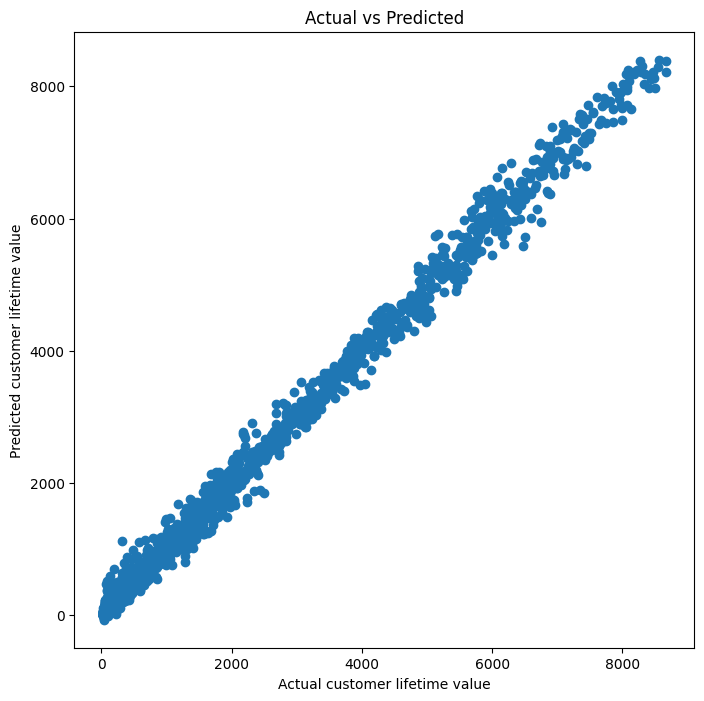

In [22]:
# plot 'gradBoost_y_pred_search' predictions against the actual values of y_test
plt.figure(figsize=(8,8))
plt.scatter(y_test, gradBoost_y_pred_search)
plt.xlabel('Actual customer lifetime value')
plt.ylabel('Predicted customer lifetime value')
plt.title('Actual vs Predicted')
plt.show()

Compare standard gradient boost model with grid search cv model using gradient boost and cross validation

In [23]:
output = f'The standard model\'s mean absolute error is {baseline_mae} and the mean squared error is {baseline_mse}. \
    The tuned model\'s mean absolute error is {search_mae} and the mean squared error is {search_mse}.'
print(output)

The standard model's mean absolute error is 1891.94 and the mean squared error is 2259.79.     The tuned model's mean absolute error is 123.58 and the mean squared error is 176.16.


In [24]:
results = pd.DataFrame(gradBoost_grid_search_model.cv_results_)
results.sort_values(by='rank_test_score')
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,...,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.007748,0.145713,0.017365,0.004538,0.01,squared_error,3,1,1,2,...,0.8,"{'learning_rate': 0.01, 'loss': 'squared_error...",0.873696,0.874522,0.872226,0.873689,0.877689,0.874364,0.001819,182
1,1.571742,0.184630,0.028381,0.012685,0.01,squared_error,3,1,1,2,...,0.8,"{'learning_rate': 0.01, 'loss': 'squared_error...",0.914326,0.915135,0.913820,0.913375,0.919316,0.915194,0.002142,155
2,1.037160,0.168582,0.018046,0.005670,0.01,squared_error,3,1,1,5,...,0.8,"{'learning_rate': 0.01, 'loss': 'squared_error...",0.873696,0.874522,0.872226,0.873689,0.877689,0.874364,0.001819,181
3,1.402266,0.156641,0.022615,0.002674,0.01,squared_error,3,1,1,5,...,0.8,"{'learning_rate': 0.01, 'loss': 'squared_error...",0.914325,0.915135,0.913820,0.913375,0.919316,0.915194,0.002142,156
4,1.079442,0.129602,0.018219,0.006241,0.01,squared_error,3,1,2,2,...,0.8,"{'learning_rate': 0.01, 'loss': 'squared_error...",0.873696,0.874522,0.872226,0.873689,0.877688,0.874364,0.001819,183


Model two, Random Forest Regressor

In [25]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_depth': [2,4,8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [1, 'sqrt', 'log2']
}

In [26]:
random_forest_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
randForest_grid_search_model = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
randForest_grid_search_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8],
                         'max_features': [1, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 300, 400]},
             scoring='neg_mean_squared_error')

In [27]:
randForest_grid_search_model.best_params_

{'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [28]:
best_randForest_model = randForest_grid_search_model.best_estimator_

In [29]:
randForest_y_pred = best_randForest_model.predict(X_test)

In [30]:
randForest_mae = round(mean_absolute_error(y_test, randForest_y_pred), 2)
randForest_mse = round(mean_squared_error(y_test, randForest_y_pred, squared=False), 2)
print(f'mean absolute error: {randForest_mae}\nmean squared error: {randForest_mse}')

mean absolute error: 132.5
mean squared error: 185.11


In [31]:
output = f'The standard model\'s mean absolute error is {baseline_mae} and the mean squared error is {baseline_mse}. \
    The tuned model\'s mean absolute error is {randForest_mae} and the mean squared error is {randForest_mse}.'
print(output)

The standard model's mean absolute error is 1891.94 and the mean squared error is 2259.79.     The tuned model's mean absolute error is 132.5 and the mean squared error is 185.11.


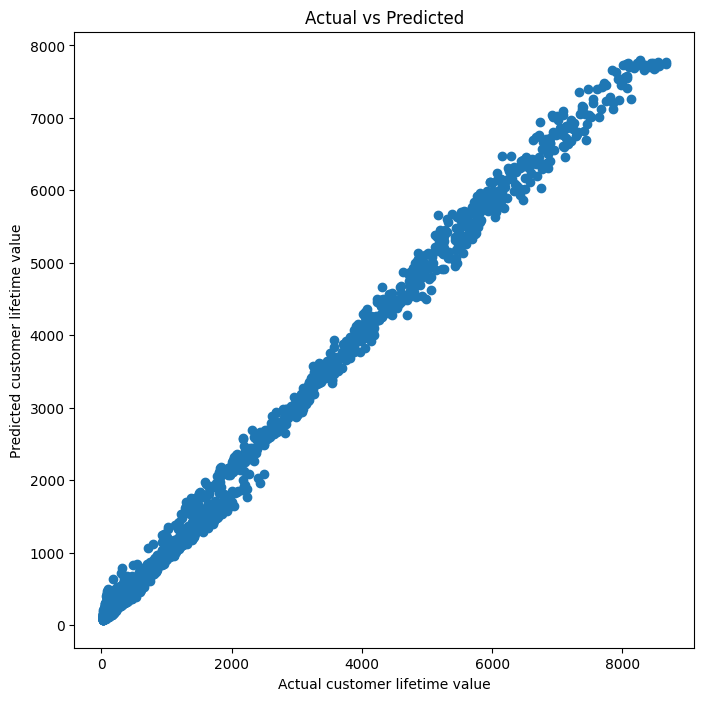

In [32]:

plt.figure(figsize=(8,8))
plt.scatter(y_test, randForest_y_pred)
plt.xlabel('Actual customer lifetime value')
plt.ylabel('Predicted customer lifetime value')
plt.title('Actual vs Predicted')
plt.show()

Model 3, AdaBoost Regressor

In [33]:
# parameter grid for AdaBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'loss': ['linear', 'square', 'exponential']
}

In [34]:
# instantiate the Adaboost model and the grid search model
AdaBoost_model = AdaBoostRegressor(random_state=42)
AdaBoost_grid_search_model = GridSearchCV(estimator=AdaBoost_model, param_grid=param_grid, n_jobs=-1, cv=5)

In [35]:
# fit the grid search model
AdaBoost_grid_search_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [50, 100, 200]})

In [36]:
# save the best model
best_AdaBoost_model = AdaBoost_grid_search_model.best_estimator_

In [37]:
# show the best parameters
AdaBoost_grid_search_model.best_params_

{'learning_rate': 1, 'loss': 'square', 'n_estimators': 200}

In [38]:
# make predictions using the best model
AdaBoost_y_pred_search = best_AdaBoost_model.predict(X_test)

In [39]:
# calculate the mean absolute error and root mean squared error
AdaBoost_mae = round(mean_absolute_error(y_test, AdaBoost_y_pred_search), 2)
AdaBoost_mse = round(mean_squared_error(y_test, AdaBoost_y_pred_search, squared=False), 2)
print(f'mean absolute error: {AdaBoost_mae}\nmean squared error: {AdaBoost_mse}')

mean absolute error: 60.55
mean squared error: 79.42


In [40]:
# compare the results of the model to baseline predictions
output = f'The standard model\'s mean absolute error is {baseline_mae} and the mean squared error is {baseline_mse}. \
    The tuned model\'s mean absolute error is {AdaBoost_mae} and the mean squared error is {AdaBoost_mse}.'
print(output)

The standard model's mean absolute error is 1891.94 and the mean squared error is 2259.79.     The tuned model's mean absolute error is 60.55 and the mean squared error is 79.42.


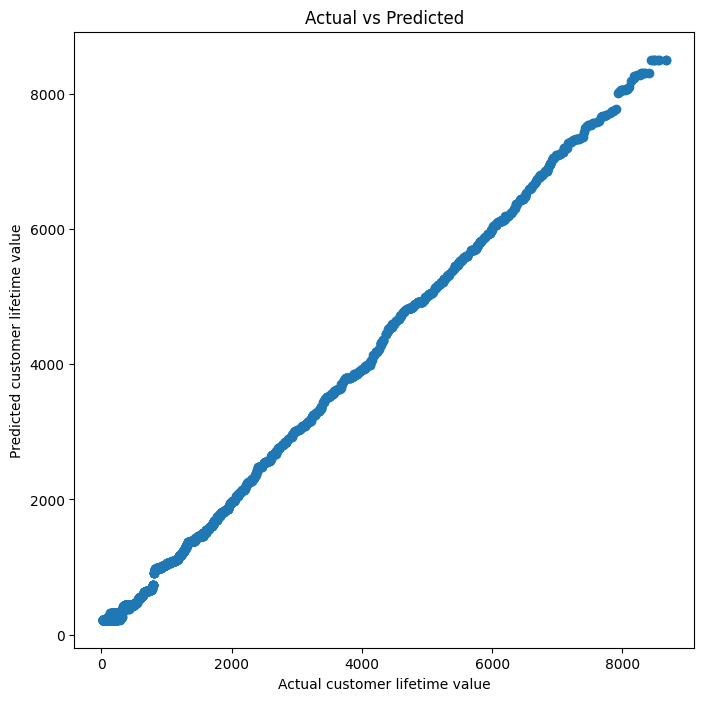

In [41]:
# plot 'AdaBoost_y_pred_search' predictions against the actual values of y_test
plt.figure(figsize=(8,8))
plt.scatter(y_test, AdaBoost_y_pred_search)
plt.xlabel('Actual customer lifetime value')
plt.ylabel('Predicted customer lifetime value')
plt.title('Actual vs Predicted')
plt.show()

Comparing the results

In [42]:
# make a dictionary of the results
results = {
    'Gradient Boosting': [search_mae, search_mse],
    'Random Forest': [randForest_mae, randForest_mse],
    'AdaBoost': [AdaBoost_mae, AdaBoost_mse]
}
results_df = pd.DataFrame(results, index=['Mean Absolute Error', 'Root Mean Squared Error'])
results_df

,Gradient Boosting,Random Forest,AdaBoost
Mean Absolute Error,123.58,132.50,60.55
Root Mean Squared Error,176.16,185.11,79.42


Sample the customers and predict their CLV

In [49]:
# get a sample from the dataset and predict the customer lifetime value
customer_sample = df_encoded.sample(n=1000, random_state=42)

# drop the sample from the dataframe
df_encoded.drop(customer_sample.index, inplace=True)

In [50]:
print(df_encoded.shape, customer_sample.shape)
customer_sample.head()

(6032, 34) (1000, 34)


,tenure,MonthlyCharges,TotalCharges,customer_lifetime_value,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,tenure_group_medium_term,tenure_group_new
2476,61,25.00,1501.75,1501.75,1,1,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
6773,19,24.70,465.85,465.85,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6116,13,102.25,1359.00,1359.00,1,0,1,0,1,0,...,1,0,0,1,1,0,0,1,0,1
3047,37,55.05,2030.75,2030.75,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,1,0
4092,6,29.45,161.45,161.45,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [53]:
X = df_encoded[best_AdaBoost_model.X_columns]
y = df_encoded['customer_lifetime_value']
len(X), len(y)

(6032, 6032)

In [54]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [55]:
# fit the model to the sample
best_AdaBoost_model.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=1, loss='square', n_estimators=200,
                  random_state=42)

In [56]:
# make predictions on the sample
X_sample = customer_sample[best_AdaBoost_model.X_columns]
y_pred = best_AdaBoost_model.predict(X_sample)

In [57]:
# score the sample
sample_mae = round(mean_absolute_error(customer_sample['customer_lifetime_value'], y_pred), 2)
sample_mse = round(mean_squared_error(customer_sample['customer_lifetime_value'], y_pred, squared=False), 2)
print(f'mean absolute error: {sample_mae}\nmean squared error: {sample_mse}')

mean absolute error: 61.13
mean squared error: 82.25


In [59]:
# compare the results of the model to baseline predictions
output = f'The standard model\'s mean absolute error is {baseline_mae} and the mean squared error is {baseline_mse}. \
    The tuned model\'s mean absolute error is {sample_mae} and the mean squared error is {sample_mse}.'
print(output)

The standard model's mean absolute error is 1891.94 and the mean squared error is 2259.79.     The tuned model's mean absolute error is 61.13 and the mean squared error is 82.25.


Save the model

In [52]:
from sklearn import __version__ as sklearn_version
import datetime

best_model = best_AdaBoost_model
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'customer_lifetime_value_model.pkl', modelpath)

A file already exists with this name.

Writing file.  "../models\customer_lifetime_value_model.pkl"


In [ ]:
data_path = '../data/processed'
save_file(df_encoded, 'preprocessed_and_modeled_data.csv', data_path)